## Global Temperature Anomalies ##


In this experiment we strive to understand and visualize one of the most important factors impacting climate change: the surface temperature.

One of the main questions outlined in the paper is the impact of climate change regarding the global water availability. Warmer temperatures inflict a substantial increase in water evaporation, thus reducing the available freshwater. Furthermore the water evaporation has an impact on precipitation patterns.

We want to compare the temperature increase to changes in precipitation and analyze whether they are similar and which regions are mostly impacted by these factors with regards to their water availability.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.patches as mpatches
import matplotlib
import sys
import os
import numpy as np
from tueplots.constants.color import rgb
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from tueplots import bundles

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 200})

# colormap for spatial plot
rb = LinearSegmentedColormap.from_list(
    "rb", [[0, 0, 153/255], [50/255, 150/255, 255/255], [1, 1, 1], [255/255, 102/255, 0], [153/255, 0, 0]], N=500
)

from netCDF4 import Dataset
import xarray as xr
import cartopy.crs as ccrs  # plotting library for geospatial data

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

### Import Timeseries Temperature Data ###
----------------------------------------------------------
Source: NOAA - Global Temperature Anomalies and Index Data

Timespan: 1850 to 2023

Base Period: 1901 to 2000

Unit: Annual Precipitation Anomaly [°C]

----------------------------------------------------------
 
First we try to obtain an overview regarding the annual temperatire anomalies over time. By doing so we might observe important trends in the data.

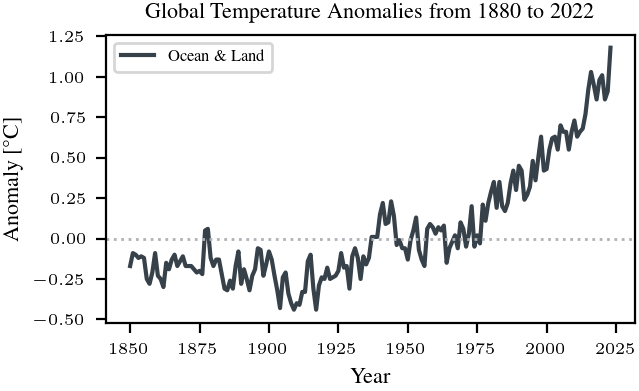

In [30]:
# lobal temperature anomalies compared to the 1901-2000 mean

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv(os.path.relpath('../dat/climate_data/temp_anomalies_annualy_timeseries.csv'), sep = ',', skiprows=4)


plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = sns.lineplot(df, x = 'Year', y = 'Anomaly', color = rgb.tue_dark, label='Ocean \& Land')
ax.set_ylabel("Anomaly [°C]")
ax.set_title("Global Temperature Anomalies from 1880 to 2022")
ax.axhline(y=0, linewidth=1, color=rgb.tue_gray, ls=':')

This plot already reveals that there seems to be a trend towards warmer temperatures on a global scale. We enhance this plot by adding a colormap and fitting a regression line.

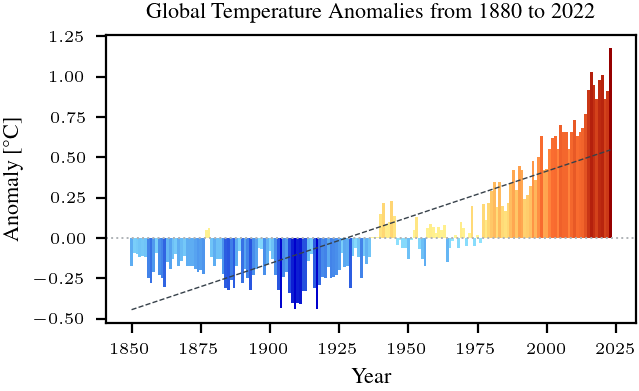

In [31]:
x = df['Year'].to_numpy()
y = df['Anomaly'].to_numpy()

plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# create colormap by stacking red cm (for values larger than 0) and blue cm (for values smaller than zero)
#colors_warm = [(1, 0.8 , 0, 0.5), (0.8, 0, 0, 1)]   # Orange, Dark Red
colors_warm = [(1, 240/255 , 0, 0.4), (1, 80/255 , 0, 0.8), (150/255, 0, 0, 1)]   # Orange, Dark Red
colors_cold = [(0, 0, 0.8, 1), (0, 0.8, 1, 0.4)]  # Dark Blue, Light Blue

cm2 = LinearSegmentedColormap.from_list('cm2', colors_warm, N=256)
cm3 = LinearSegmentedColormap.from_list('cm3', colors_cold, N=256)

newcolors = np.vstack((cm3(np.linspace(0, 1, 128)),
                       cm2(np.linspace(0, 1, 128))))

warm_cold_cm = ListedColormap(newcolors, name='RedBlue')

# since colormap scales colors according to values between 0 and one, we want to 
# assign anomalies > 0 a value between 0.5 and 1, so its drawn orange / red and anomalies
# and assign anomalies <0 a value between 0 and 0.5 so its drawn blue
def rescale(y):
    result = np.zeros(y.shape)
    for i in range(0, y.shape[0]):
        elem = y[i]
        if elem >= 0:
            result[i] = elem / (2*np.max(y)) + 0.5
        else:
            result[i] = np.abs(elem) / (2*np.min(y)) + 0.5
    return result
    

# plot anomalies over years
ax.bar(x, y, color=warm_cold_cm(rescale(y)), width=1)
ax.axhline(y=0, linewidth=0.7, color=rgb.tue_gray, ls=':')
ax.set_xlabel("Year")
ax.set_ylabel("Anomaly [°C]")
ax.set_title("Global Temperature Anomalies from 1880 to 2022")

#add regression line
b,a = np.polyfit(x, y, deg = 1)
xseq = np.linspace(np.min(x), np.max(x), num=100)
ax.plot(xseq, a + b * xseq, color=rgb.tue_dark, lw=0.5, ls='--')

We can clearly observe, that there is a trend towards a warmer climate compared to the baseline average. The regression line clearly visualizes this. For the year 2023, the global average temperature was more than one degree warmer compared to the baseline average between 1901 and 2000.

Next we want to check, how different regions are impacted by the temperature anomalies. To do so we use a gridded dataset containing geospatial data.

### Import Spatial Temperature Data ###
----------------------------------------------------------

Source: NOAA - GlobalTemp, NCEI Data Portal

Timespan: 1850/01 to 2022/12

Baseline: 1971 to 2000

Unit: Monthly Temperature Anomalies [°C]

----------------------------------------------------------

In [32]:
# temp anomalies compared to the 1971–2000 mean

data = xr.open_dataset("../dat/climate_data/NOAAGlobalTemp_v5.0.0_gridded_s188001_e202212_c20230108T133308.nc")
df = data.to_dataframe()
df.head()

anom
time       lat   lon  z        
1880-01-01 -87.5 2.5  0.0   NaN
                 7.5  0.0   NaN
                 12.5 0.0   NaN
                 17.5 0.0   NaN
                 22.5 0.0   NaN

The datapoints for the year 2022 are extracted and averaged.

In [37]:
# average data over whole year 2022

# select data for each month of year 2022
dt64_start = np.datetime64('2022-01-01T00:00:00.000000000')
dt64_end = np.datetime64('2022-12-01T00:00:00.000000000')

filtered_data = data.sel(time=slice(dt64_start, dt64_end))
# dataframe now contains 12 months
filtered_data


<xarray.Dataset>
Dimensions:  (time: 12, lat: 36, lon: 72, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-12-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (time, z, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P143Y0M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2023-01-08T18:33:09Z
    date_issued:                     2023-01-08T18:33:09Z

In [38]:
# average over all 12 months
filtered_data = filtered_data.mean(dim = ("time"))
filtered_data

<xarray.Dataset>
Dimensions:  (lat: 36, lon: 72, z: 1)
Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (z, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

The average annual temperature anomalies for the year 2022 are visualized.

Text(0.5, 1.0, 'Surface Temperature Anomalies - Year 2022')

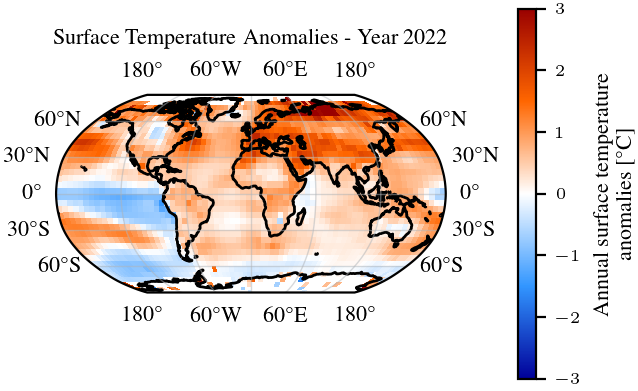

In [39]:
# Create a plot
plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
#ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.coastlines()
plot = filtered_data["anom"].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=rb, vmin=-3, vmax=3, add_colorbar=False)
# rename colorbar label
cb = plt.colorbar(mappable=plot, label = 'Annual surface temperature \n anomalies [°C]')

# add gridlines to globe
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=.5,
    color=rgb.tue_gray,
    alpha=0.5,
    linestyle="-",
)

gl.top_labels = True
gl.right_labels = True
ax.set_title("Surface Temperature Anomalies - Year 2022")

One can see that almost all countries were impacted by higher temperatures in the year 2022 due to climate change. Even though some areas have severely higher anomalies then others, the temperature increase seems to be a global phenomenon.

Comparing this result to the precipitation changes (precipitation.ipynb) it can be observed that the temperature increases globally, however a decrease in rainfall is a regional phenomenon rather than a global one.